In [2]:
import pandas as pd
from glob import glob

def process_tripdata(df):

    df['starttime'] = pd.to_datetime(df['starttime'])
    df['stoptime']  = pd.to_datetime(df['stoptime'])

    df = pd.get_dummies(
        df,
        columns=['usertype'],
        prefix='usertype',
        dtype=float
    )

    # starttime components
    df['start_date']   = df['starttime'].dt.date
    df['start_hour']   = df['starttime'].dt.hour
    df['start_minute'] = df['starttime'].dt.minute
    df['start_second'] = df['starttime'].dt.second

    # stoptime components
    df['stop_date']   = df['stoptime'].dt.date
    df['stop_hour']   = df['stoptime'].dt.hour
    df['stop_minute'] = df['stoptime'].dt.minute
    df['stop_second'] = df['stoptime'].dt.second

    df.drop(columns=['starttime', 'stoptime'], inplace=True)

    return df


In [3]:
files = sorted(glob("JC-2018*-citibike-tripdata.csv"))
files


['JC-201801-citibike-tripdata.csv',
 'JC-201802-citibike-tripdata.csv',
 'JC-201803-citibike-tripdata.csv',
 'JC-201804-citibike-tripdata.csv',
 'JC-201805-citibike-tripdata.csv',
 'JC-201806-citibike-tripdata.csv',
 'JC-201807-citibike-tripdata.csv',
 'JC-201808-citibike-tripdata.csv',
 'JC-201809-citibike-tripdata.csv',
 'JC-201810-citibike-tripdata.csv',
 'JC-201811-citibike-tripdata.csv',
 'JC-201812-citibike-tripdata.csv']

In [4]:
processed = {}  # dict to store: processed['201801'] = df

for f in files:
    print(f"Loading {f} ...")
    df = pd.read_csv(f, low_memory=False)

    print("Processing...")
    df = process_tripdata(df)

    # Extract month key, e.g. "201801"
    key = f.split("JC-")[1].split("-")[0]

    processed[key] = df
    print(f"Done → stored as processed['{key}'] ({df.shape[0]} rows)")


Loading JC-201801-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201801'] (12677 rows)
Loading JC-201802-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201802'] (15104 rows)
Loading JC-201803-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201803'] (17109 rows)
Loading JC-201804-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201804'] (23634 rows)
Loading JC-201805-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201805'] (34456 rows)
Loading JC-201806-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201806'] (40937 rows)
Loading JC-201807-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201807'] (42268 rows)
Loading JC-201808-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201808'] (44432 rows)
Loading JC-201809-citibike-tripdata.csv ...
Processing...
Done → stored as processed['201809'] (39022 rows)
Loading JC-201810-citibike-t

In [5]:
for key, df in processed.items():
    outname = f"JC-{key}-processed.parquet"
    df.to_parquet(outname)
    print(f"Saved {outname}")


Saved JC-201801-processed.parquet
Saved JC-201802-processed.parquet
Saved JC-201803-processed.parquet
Saved JC-201804-processed.parquet
Saved JC-201805-processed.parquet
Saved JC-201806-processed.parquet
Saved JC-201807-processed.parquet
Saved JC-201808-processed.parquet
Saved JC-201809-processed.parquet
Saved JC-201810-processed.parquet
Saved JC-201811-processed.parquet
Saved JC-201812-processed.parquet


In [6]:
import pandas as pd

# Collect into lists for plotting
months = []
num_trips = []
avg_tripduration = []
customers = []
subscribers = []
unique_start = []
unique_end = []
gender_male = []
gender_female = []
gender_unknown = []
missing_matrix = []

for key, df in processed.items():
    months.append(key)

    num_trips.append(len(df))
    avg_tripduration.append(df["tripduration"].mean())

    customers.append(df["usertype_Customer"].sum())
    subscribers.append(df["usertype_Subscriber"].sum())

    unique_start.append(df[["start station id"]].drop_duplicates().shape[0])
    unique_end.append(df[["end station id"]].drop_duplicates().shape[0])

    # Gender distribution
    counts = df["gender"].value_counts()
    gender_male.append(counts.get(1, 0))
    gender_female.append(counts.get(2, 0))
    gender_unknown.append(counts.get(0, 0))

    # Missing values per column
    missing_matrix.append(df.isna().sum().values)

# Make missing matrix a DataFrame for heatmap
missing_df = pd.DataFrame(
    missing_matrix,
    index=months,
    columns=processed[months[0]].columns
)


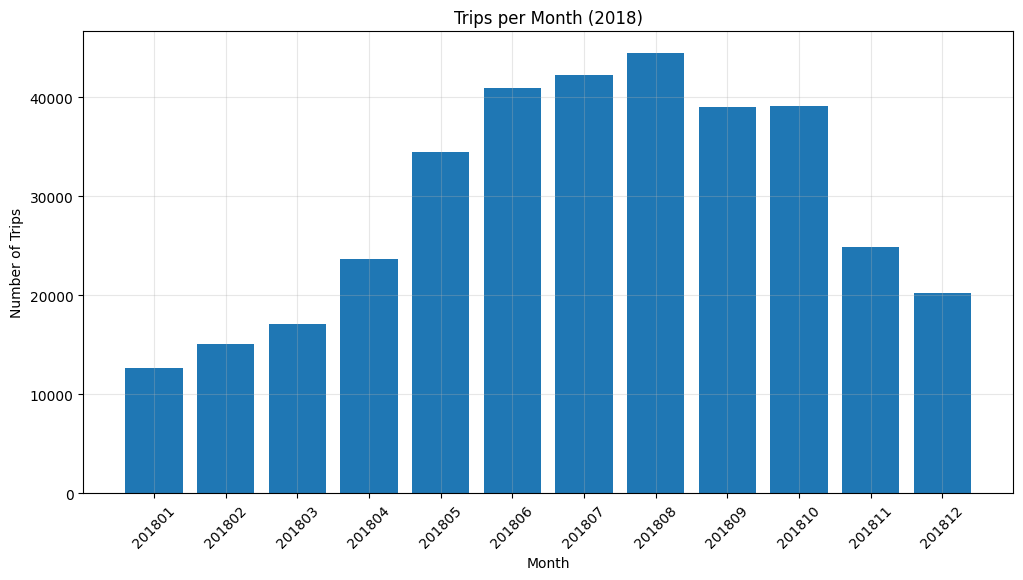

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(months, num_trips)
plt.title("Trips per Month (2018)")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


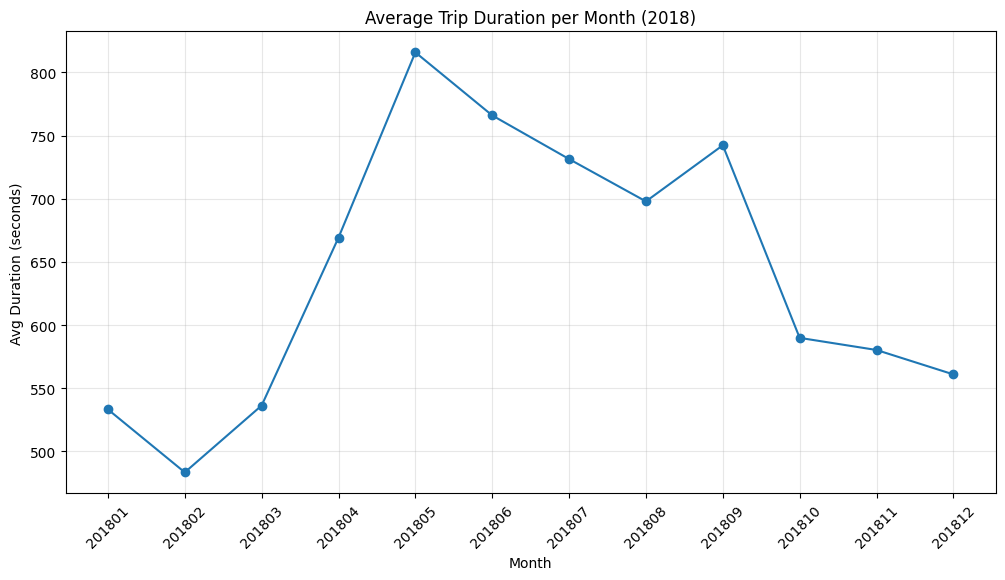

In [8]:
plt.figure(figsize=(12,6))
plt.plot(months, avg_tripduration, marker='o')
plt.title("Average Trip Duration per Month (2018)")
plt.xlabel("Month")
plt.ylabel("Avg Duration (seconds)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


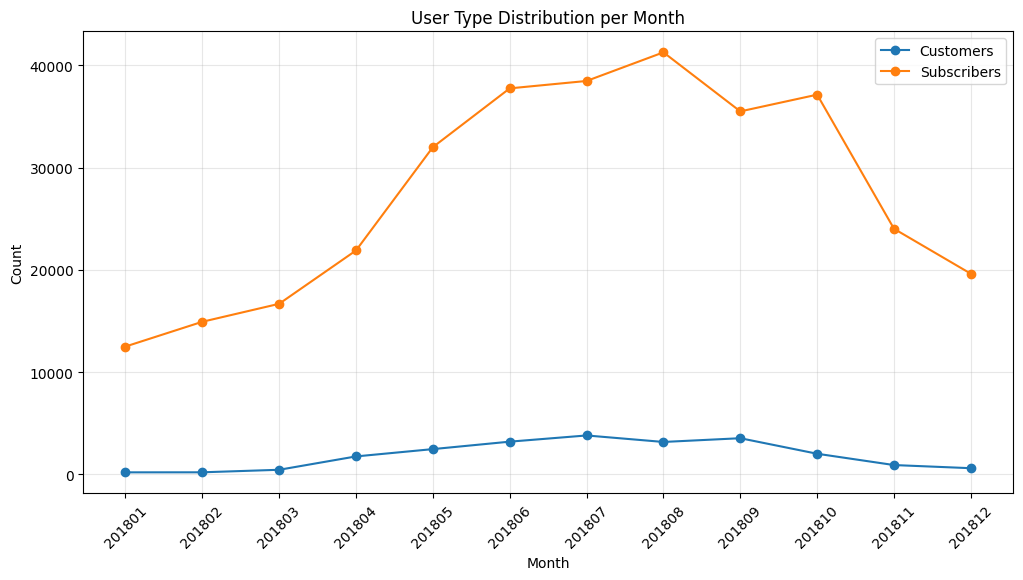

In [9]:
plt.figure(figsize=(12,6))

plt.plot(months, customers, marker='o', label="Customers")
plt.plot(months, subscribers, marker='o', label="Subscribers")

plt.title("User Type Distribution per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


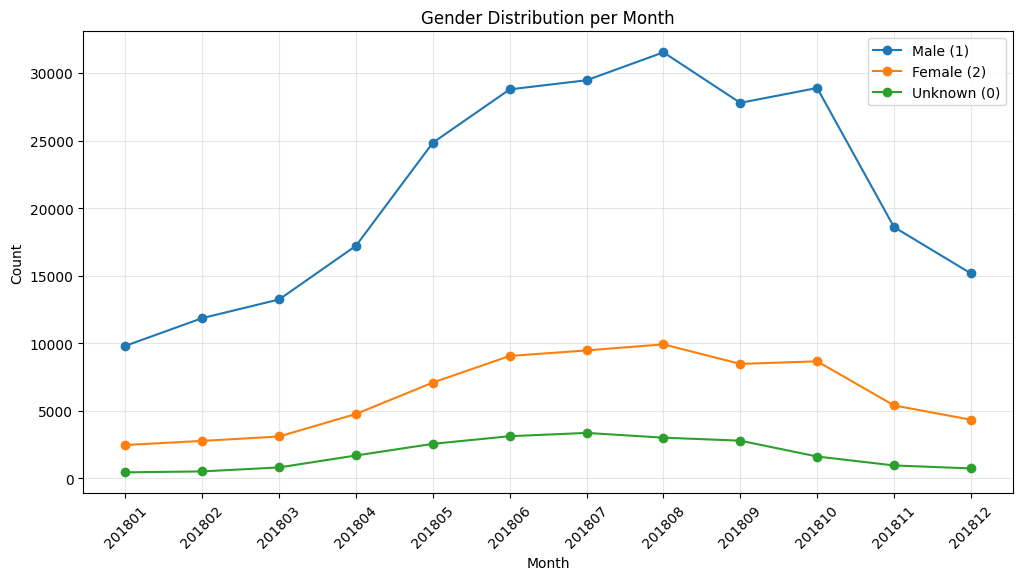

In [10]:
plt.figure(figsize=(12,6))

plt.plot(months, gender_male, marker='o', label="Male (1)")
plt.plot(months, gender_female, marker='o', label="Female (2)")
plt.plot(months, gender_unknown, marker='o', label="Unknown (0)")

plt.title("Gender Distribution per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
df_year = pd.concat(processed.values(), ignore_index=True)


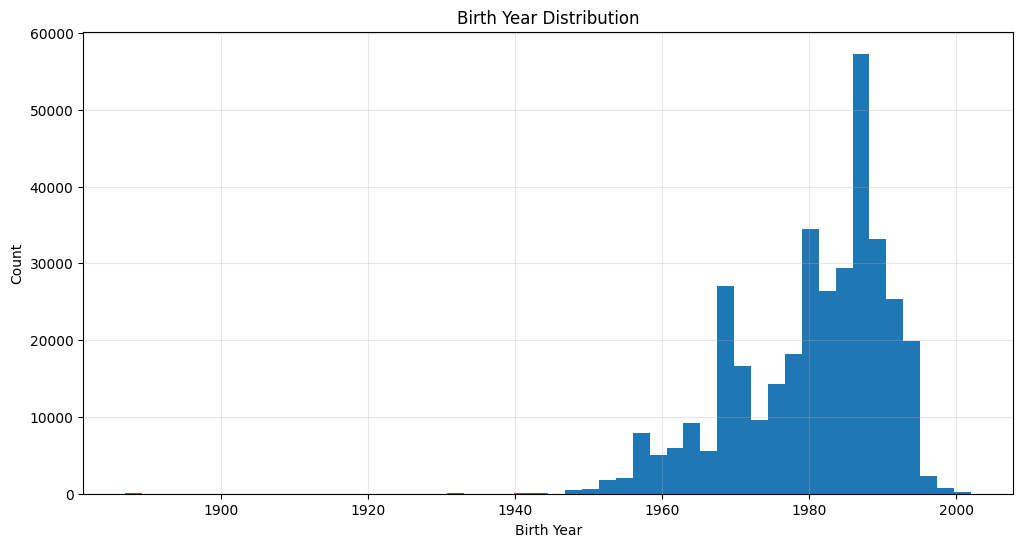

In [12]:
plt.figure(figsize=(12,6))
plt.hist(df_year["birth year"].dropna(), bins=50)
plt.title("Birth Year Distribution")
plt.xlabel("Birth Year")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()


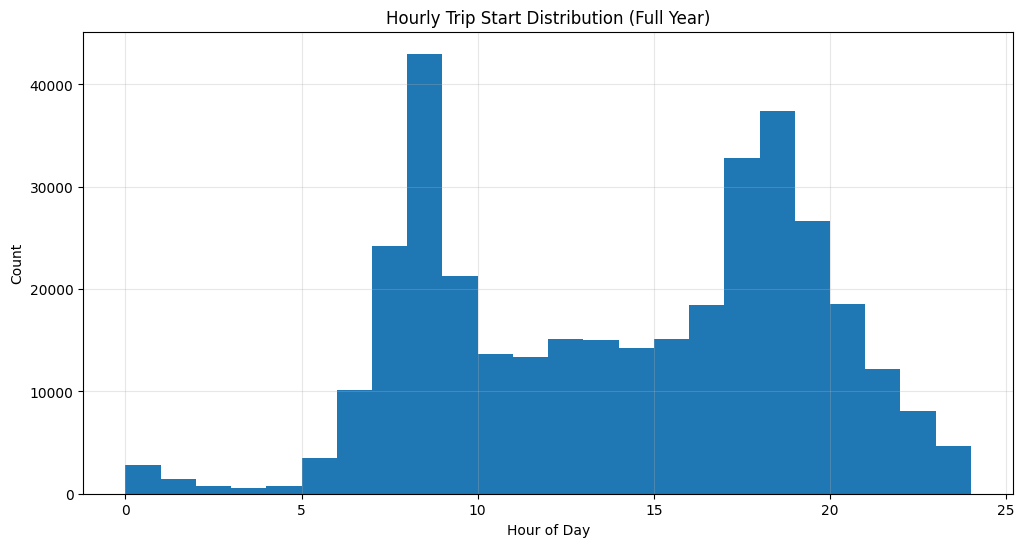

In [13]:
plt.figure(figsize=(12,6))
plt.hist(df_year["start_hour"], bins=24, range=(0,24))
plt.title("Hourly Trip Start Distribution (Full Year)")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()


In [19]:
import pandas as pd

unique_start = []
unique_end = []

print("→ Checking which months are being processed:")
print(list(processed.keys()))  # sanity check

for key, df in processed.items():
    print(f"  - Processing month: {key}   (rows: {len(df)})")

    # Collect full station info
    s = df[[
        'start station id',
        'start station name',
        'start station latitude',
        'start station longitude'
    ]].dropna().drop_duplicates()

    e = df[[
        'end station latitude',
        'end station longitude'
    ]].dropna().drop_duplicates()

    unique_start.append(s)
    unique_end.append(e)

# Merge all months into one table of unique stations
unique_start = (
    pd.concat(unique_start)
      .drop_duplicates(subset=[
          'start station id',
          'start station name',
          'start station latitude',
          'start station longitude'
      ])
      .reset_index(drop=True)
)

unique_end = (
    pd.concat(unique_end)
      .drop_duplicates(subset=[
          'end station latitude',
          'end station longitude'
      ])
      .reset_index(drop=True)
)

print("\n=============================================")
print("Unique Start Stations Across All 2018:", len(unique_start))
print("=============================================\n")

print(unique_start.head())


→ Checking which months are being processed:
['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812']
  - Processing month: 201801   (rows: 12677)
  - Processing month: 201802   (rows: 15104)
  - Processing month: 201803   (rows: 17109)
  - Processing month: 201804   (rows: 23634)
  - Processing month: 201805   (rows: 34456)
  - Processing month: 201806   (rows: 40937)
  - Processing month: 201807   (rows: 42268)
  - Processing month: 201808   (rows: 44432)
  - Processing month: 201809   (rows: 39022)
  - Processing month: 201810   (rows: 39138)
  - Processing month: 201811   (rows: 24910)
  - Processing month: 201812   (rows: 20205)

Unique Start Stations Across All 2018: 59

   start station id start station name  start station latitude  \
0              3183     Exchange Place               40.716247   
1              3184        Paulus Hook               40.714145   
2              3185          City Hall              

In [20]:
all_stations = pd.concat([
    unique_start.rename(columns={
        'start station latitude': 'lat',
        'start station longitude': 'lon'
    }),
    unique_end.rename(columns={
        'end station latitude': 'lat',
        'end station longitude': 'lon'
    })
]).drop_duplicates().reset_index(drop=True)

print("Total unique stations (start ∪ end):", len(all_stations))


Total unique stations (start ∪ end): 183


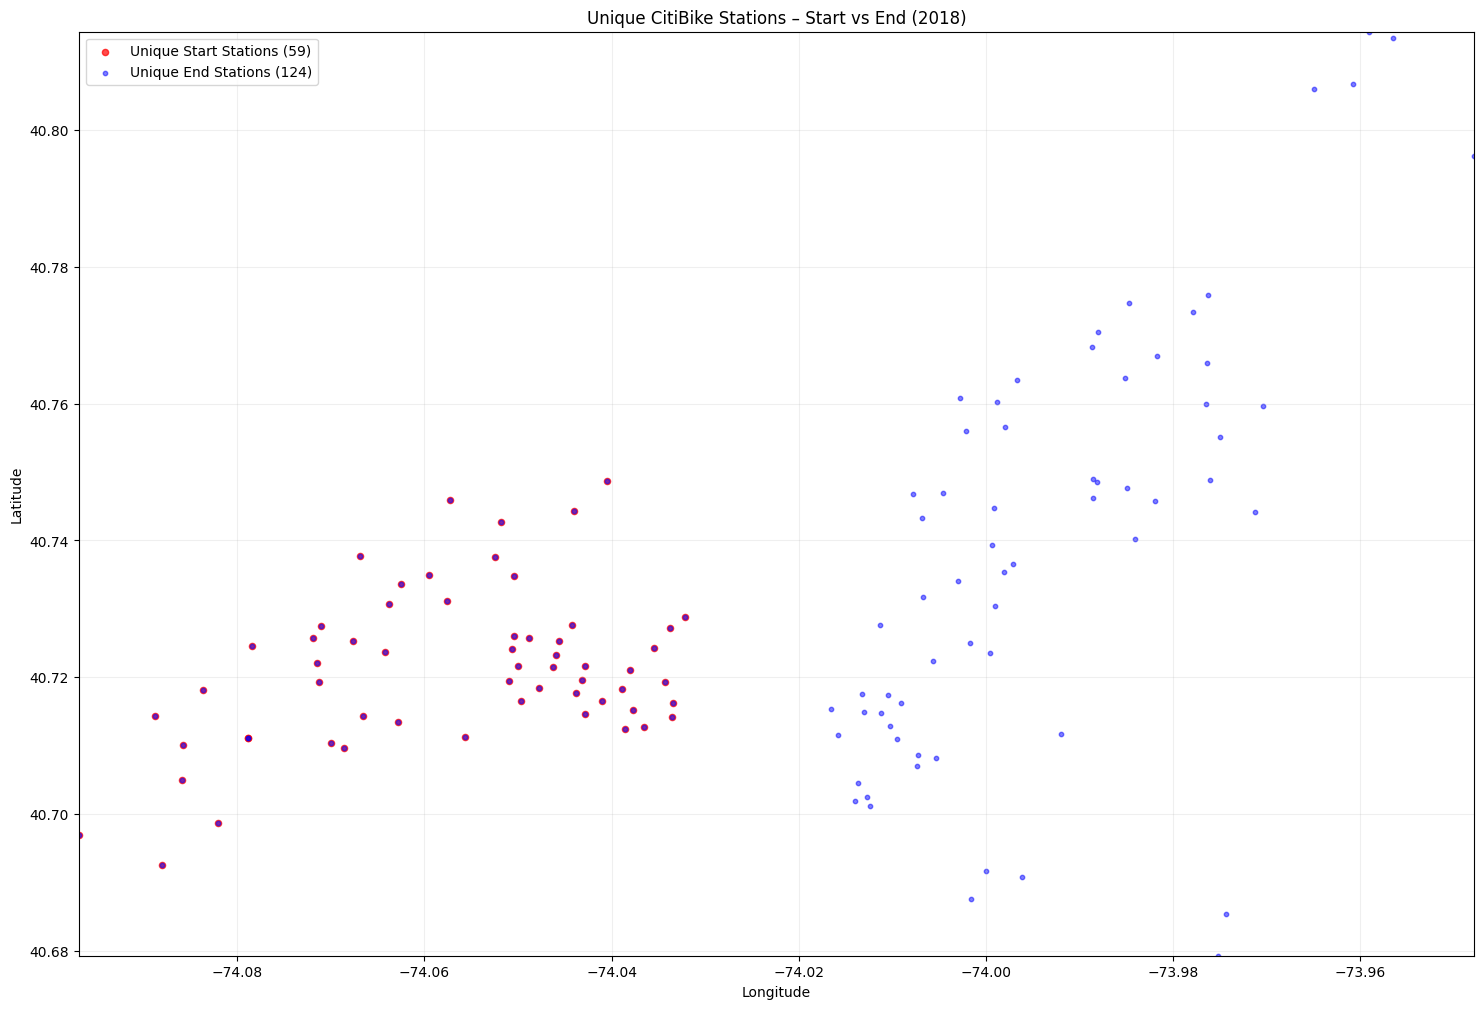

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

# Start stations (unique)
plt.scatter(
    unique_start['start station longitude'],
    unique_start['start station latitude'],
    s=20,
    c='red',
    alpha=0.7,
    label=f"Unique Start Stations ({len(unique_start)})"
)

# End stations (unique)
plt.scatter(
    unique_end['end station longitude'],
    unique_end['end station latitude'],
    s=10,
    c='blue',
    alpha=0.5,
    label=f"Unique End Stations ({len(unique_end)})"
)

# Determine plot bounds
xmin = min(unique_start['start station longitude'].min(),
           unique_end['end station longitude'].min())
xmax = max(unique_start['start station longitude'].max(),
           unique_end['end station longitude'].max())
ymin = min(unique_start['start station latitude'].min(),
           unique_end['end station latitude'].min())
ymax = max(unique_start['start station latitude'].max(),
           unique_end['end station latitude'].max())

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Unique CitiBike Stations – Start vs End (2018)")

plt.legend()
plt.grid(True, alpha=0.2)

plt.show()


K MEANS

In [22]:
import numpy as np
import pandas as pd

# Collect coordinates from all months
coords = []

for key, df in processed.items():
    s = df[['start station latitude', 'start station longitude']].dropna()
    coords.append(s)

# Combine and deduplicate
coords = pd.concat(coords).drop_duplicates().reset_index(drop=True)

print("Unique start stations:", len(coords))

# Convert to numpy array
start_coords = coords[['start station latitude', 'start station longitude']].to_numpy()

lat = start_coords[:, 0]
lon = start_coords[:, 1]


Unique start stations: 59


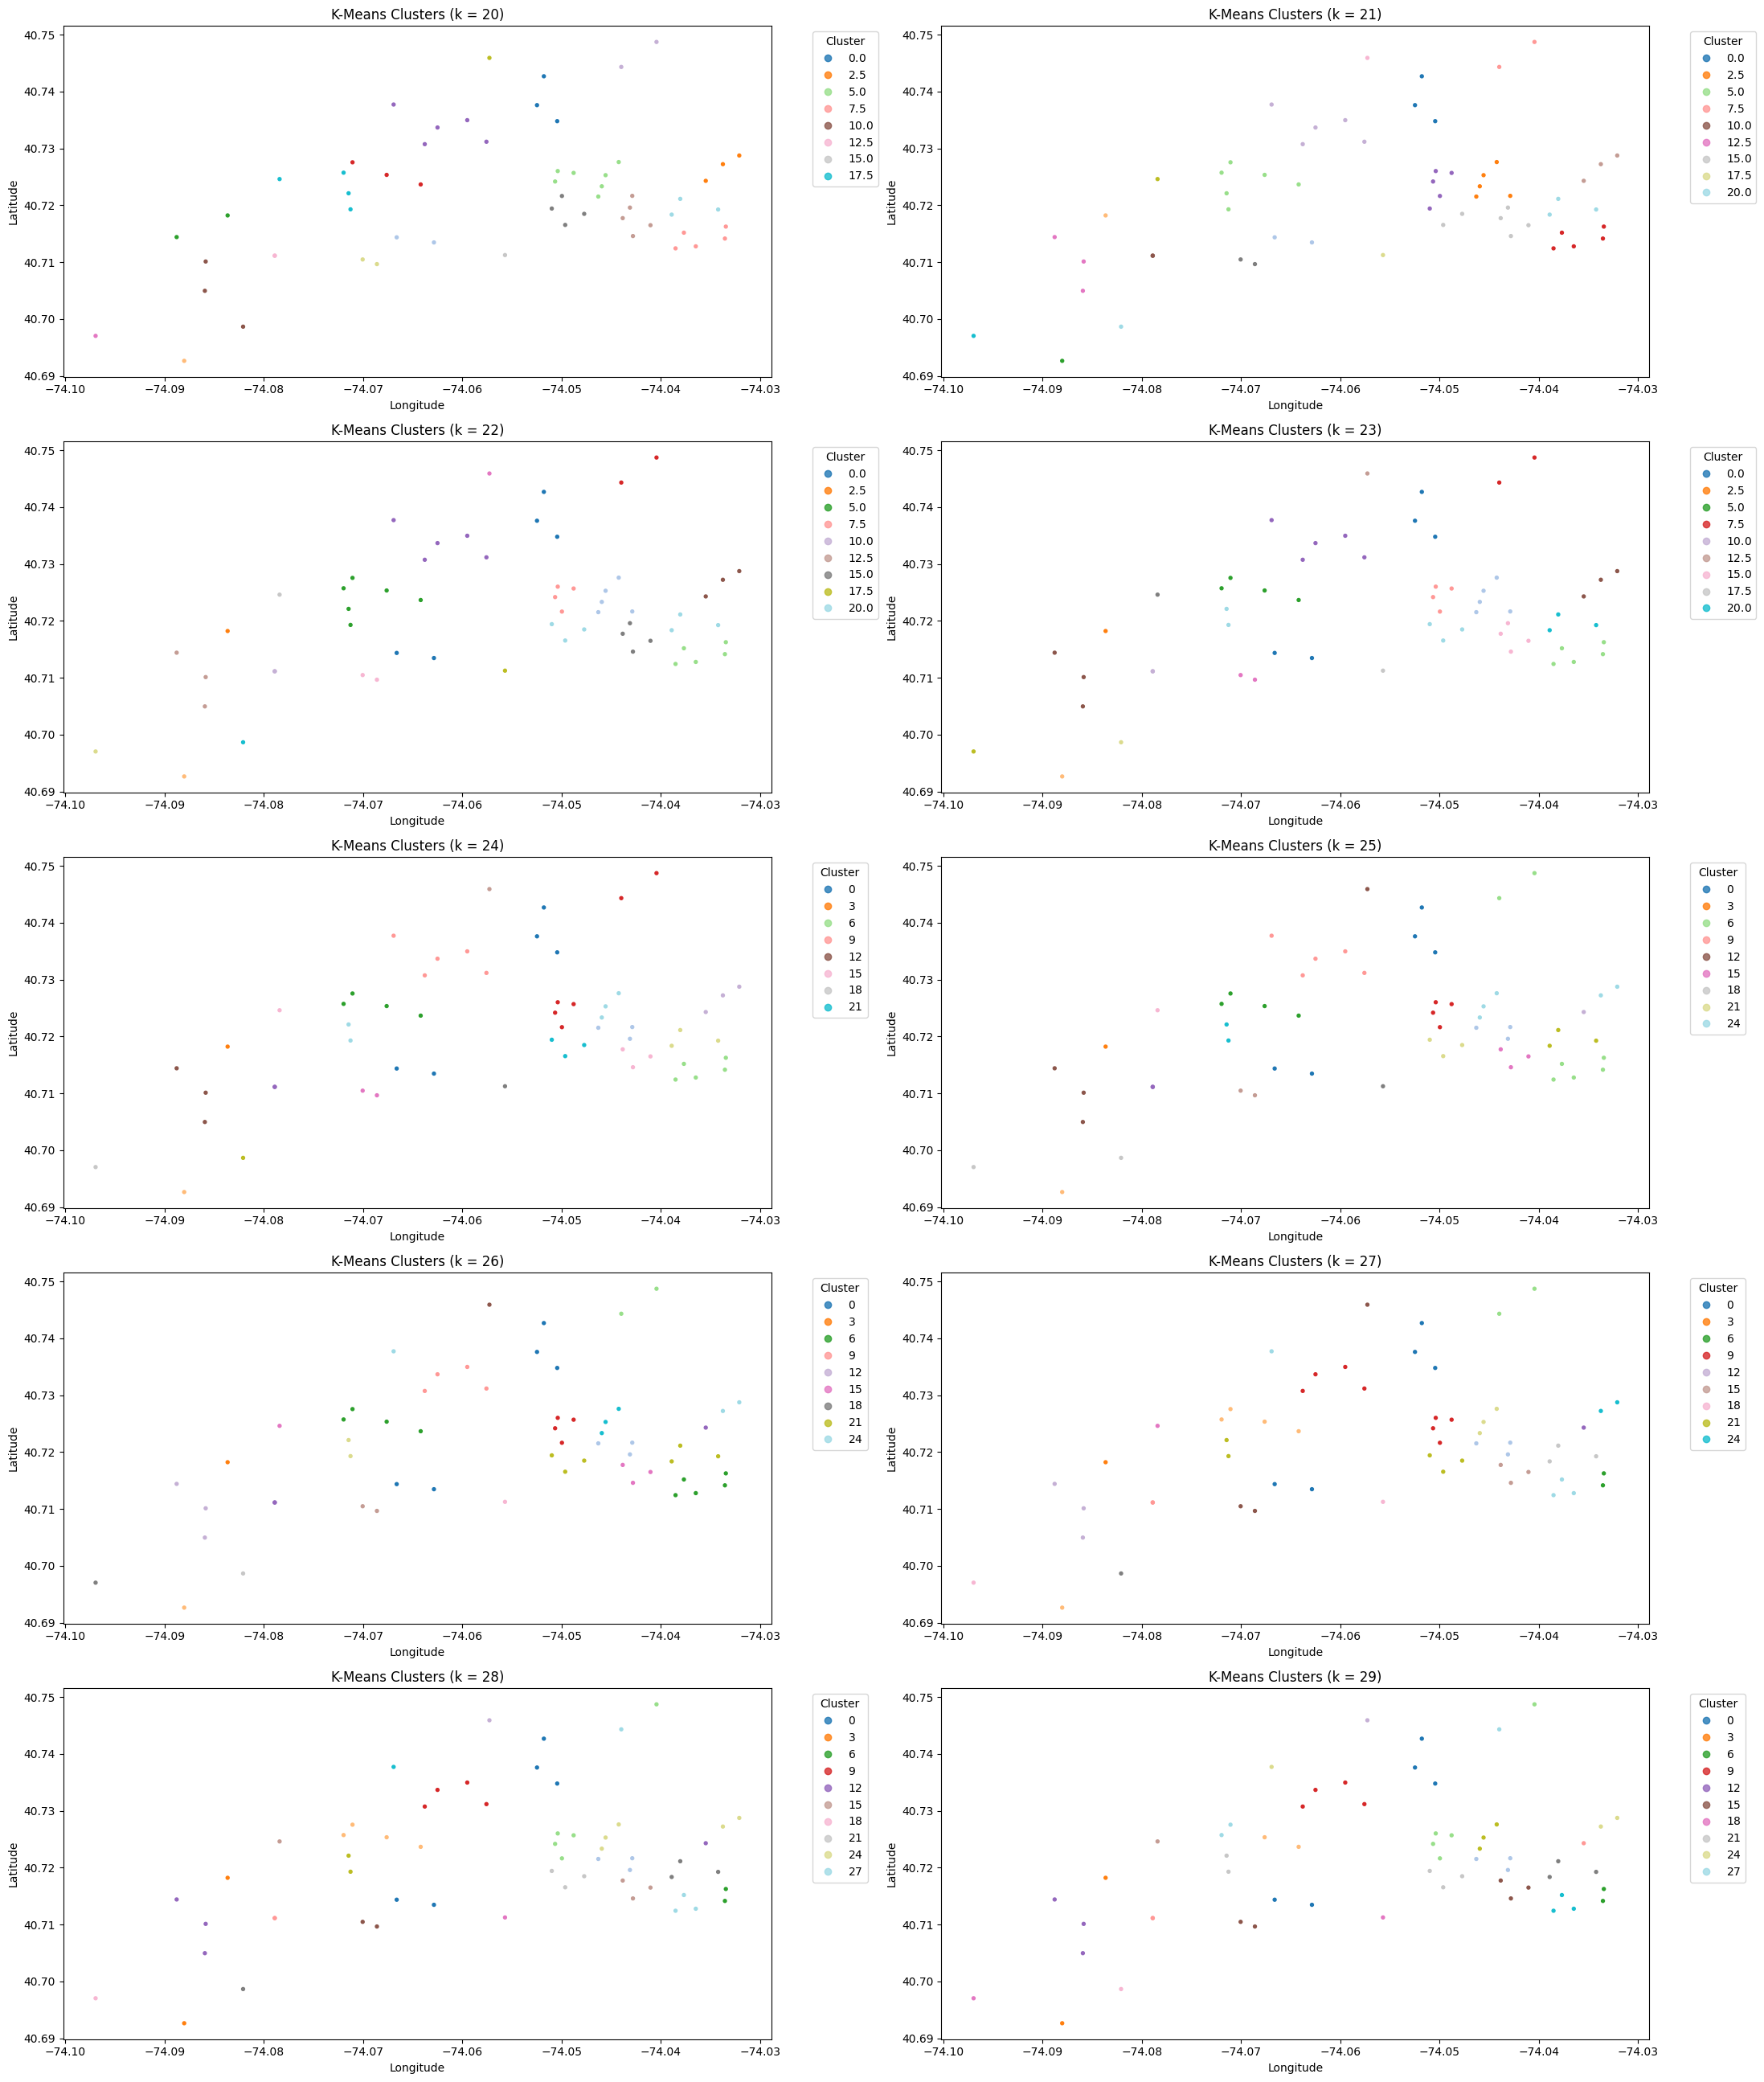

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of k
k_values = range(20, 30)

plt.figure(figsize=(22, 26))

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(start_coords)
    
    # Plot each subplot
    plt.subplot(5, 2, i + 1)
    scatter = plt.scatter(lon, lat, c=labels, s=8, cmap="tab20")

    plt.title(f"K-Means Clusters (k = {k})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Legend for cluster IDs
    handles, legend_labels = scatter.legend_elements(prop="colors", alpha=0.8)
    plt.legend(handles, legend_labels, title="Cluster", 
               bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


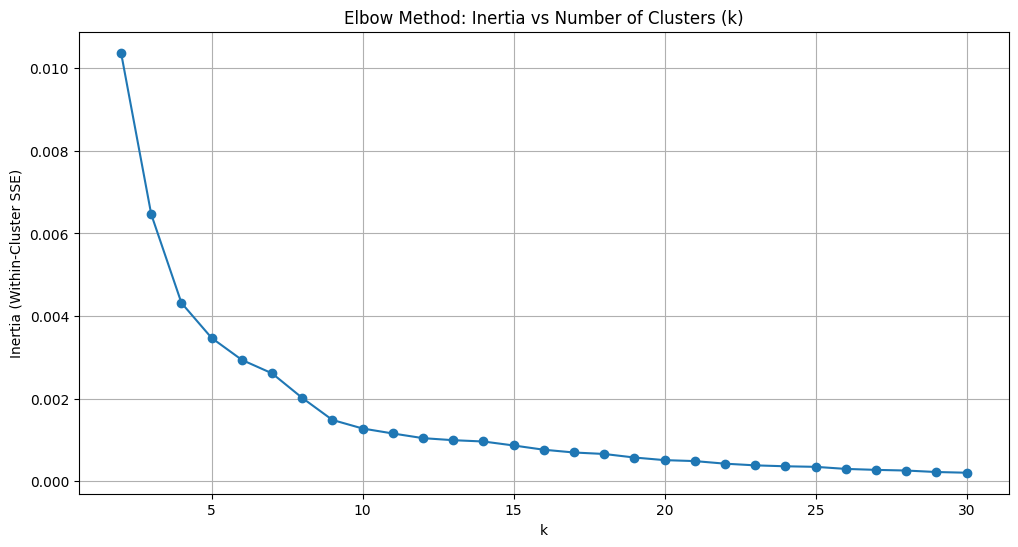

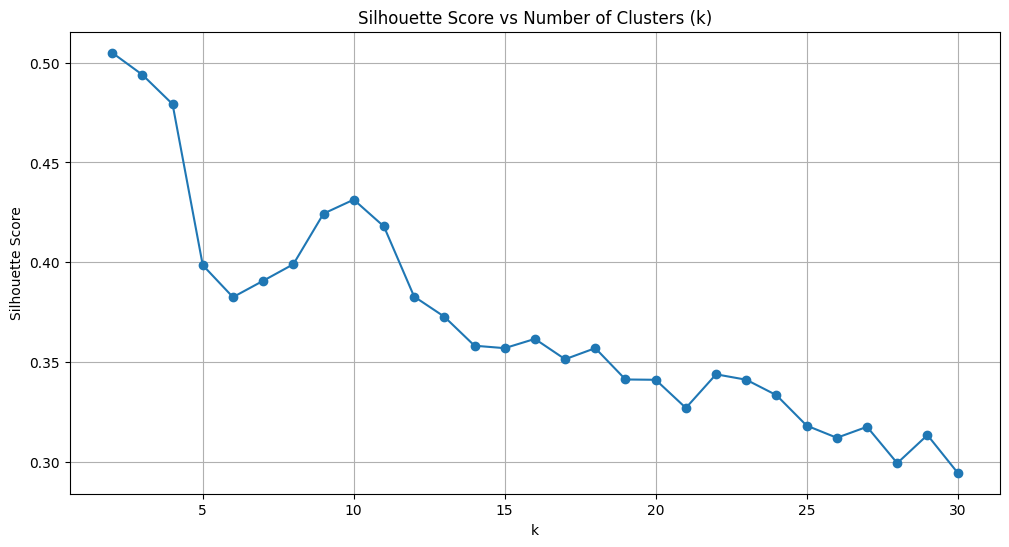

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 31)
inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(start_coords)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(start_coords, labels))

# Elbow method plot
plt.figure(figsize=(12, 6))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method: Inertia vs Number of Clusters (k)")
plt.xlabel("k")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.grid(True)
plt.show()

# Silhouette plot
plt.figure(figsize=(12, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

X = start_coords    # shape (59, 2)
print("Unique start stations:", X.shape[0])


Unique start stations: 59


In [26]:
k_values = range(2, 31)
sil_scores = []

print("\nStarting Gaussian Mixture (GMM) clustering over unique stations...\n")

for k in k_values:
    print(f"→ Fitting GMM with {k} components...")

    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(X)

    # Compute silhouette
    try:
        score = silhouette_score(X, labels)
        print(f"   ✓ Silhouette score = {score:.4f}\n")
        sil_scores.append(score)
    except Exception as e:
        print(f"   ✗ Silhouette failed for k={k}: {e}\n")
        sil_scores.append(np.nan)



Starting Gaussian Mixture (GMM) clustering over unique stations...

→ Fitting GMM with 2 components...
   ✓ Silhouette score = 0.4217

→ Fitting GMM with 3 components...
   ✓ Silhouette score = 0.4939

→ Fitting GMM with 4 components...
   ✓ Silhouette score = 0.4792

→ Fitting GMM with 5 components...
   ✓ Silhouette score = 0.3307

→ Fitting GMM with 6 components...
   ✓ Silhouette score = 0.3386

→ Fitting GMM with 7 components...
   ✓ Silhouette score = 0.3304

→ Fitting GMM with 8 components...
   ✓ Silhouette score = 0.3753

→ Fitting GMM with 9 components...
   ✓ Silhouette score = 0.3948

→ Fitting GMM with 10 components...
   ✓ Silhouette score = 0.4023

→ Fitting GMM with 11 components...
   ✓ Silhouette score = 0.4238

→ Fitting GMM with 12 components...
   ✓ Silhouette score = 0.3828

→ Fitting GMM with 13 components...
   ✓ Silhouette score = 0.3727

→ Fitting GMM with 14 components...
   ✓ Silhouette score = 0.3582

→ Fitting GMM with 15 components...
   ✓ Silhouette sco

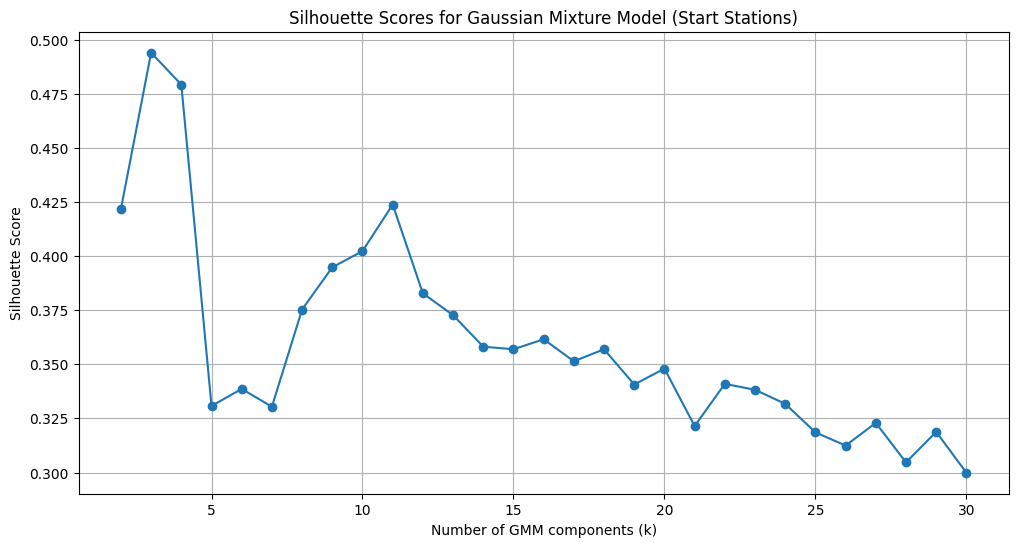

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of GMM components (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Gaussian Mixture Model (Start Stations)")
plt.grid(True)
plt.show()


In [28]:
best_k = k_values[int(np.nanargmax(sil_scores))]
print(f"Best number of clusters according to silhouette: k = {best_k}")

# Fit final model
gmm = GaussianMixture(n_components=20, random_state=42)
labels = gmm.fit_predict(X)


Best number of clusters according to silhouette: k = 3


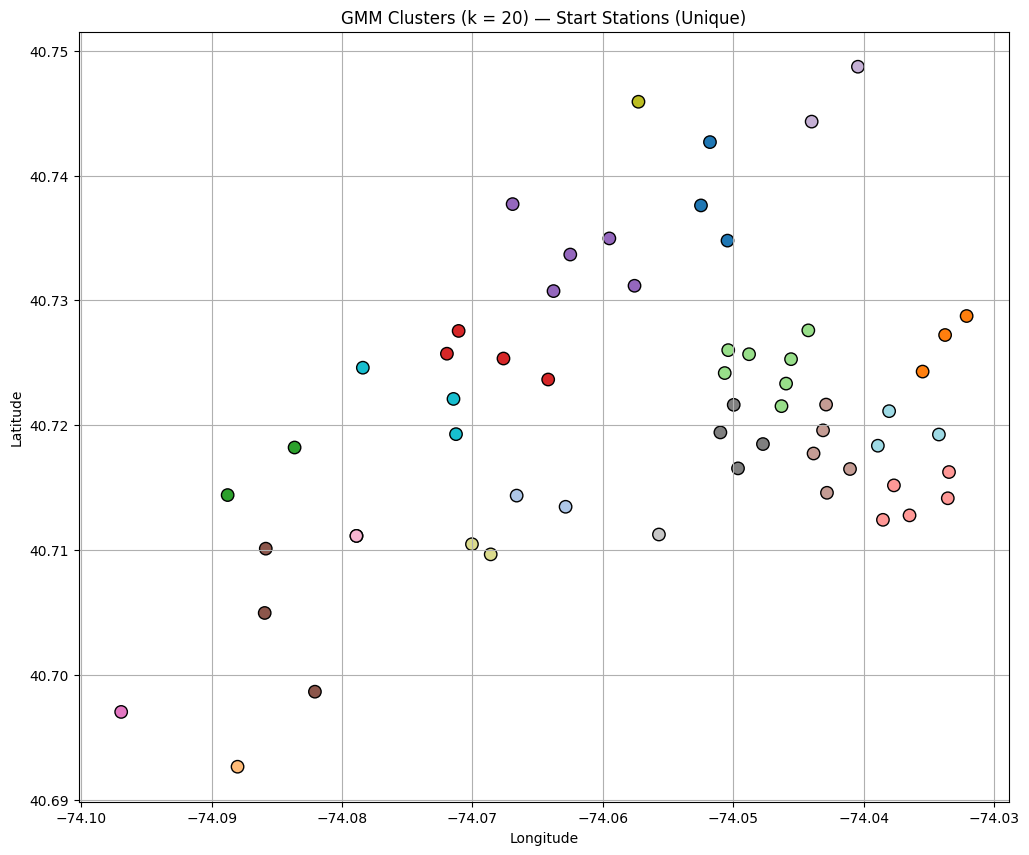

In [29]:
plt.figure(figsize=(12, 10))

plt.scatter(
    lon, lat,
    c=labels,
    cmap='tab20',
    s=80,
    edgecolor='black'
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"GMM Clusters (k = 20) — Start Stations (Unique)")
plt.grid(True)
plt.show()
